### Run in Google CoLab! (Open in new window or new tab)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m-wessler/nbm-verify/blob/master/notebooks/verify_1Dqpf_dev.ipynb)

In [1]:
import os
import csv
import urllib.request as req

import numpy as np
import pandas as pd
import xarray as xr

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_1d_csv(get_req, this, total):

    _date, _init_hour, _url = get_req
    
    try:
        response = req.urlopen(_url).read().decode('utf-8')
        print('\r[%d/%d] %s %s'%(this, total, _date, _init_hour), end='')
        
    except:
        print('\r[%d/%d] NOT FOUND %s %s'%(this, total, _date, _init_hour), end='')
        return None
    
    else:
        init = datetime(_date.year, _date.month, _date.day, _init_hour, 0)

        response = response.split('\n')
        header = np.append('InitTime', response[0].split(','))
        
        lines = []
        for line in response[1:]:
            line = line.split(',')

            try:
                line[0] = datetime.strptime(line[0], '%Y%m%d%H')
            except:
                pass
            else:
                lines.append(np.append(init, line))
                        
        return header, lines

In [3]:
def get_precip_obs(s, d0, d1):
    import requests

    # Tokens registered to michael.wessler@noaa.gov
    api_token = 'a2386b75ecbc4c2784db1270695dde73'
    api_key = 'Kyyki2tc1ETHUgShiscycW15e1XI02SzRXTYG28Dpg'
    base = 'https://api.synopticdata.com/v2/stations/precip?'
    
    allints = []
    
    forecast_interval = 6
    for interval in [6, 12, 24]:
        
        # Limit how big the observation lag can be (minutes)
        lag_limit = (interval/2)*60
        repeat = int((interval-forecast_interval)/6)+1
        
        df = []
        while repeat > 0:
            print('Working: Interval {}h Iteration {}'.format(interval, repeat))
                        
            _d0 = d0+timedelta(hours=(forecast_interval)*(repeat-1))
            _d1 = d1+timedelta(hours=1+forecast_interval*(repeat-1))
            
            url = base + 'stid={}&start={}&end={}&pmode=intervals&interval={}&token={}'.format(
                s,
                datetime.strftime(_d0, '%Y%m%d%H%M'),
                datetime.strftime(_d1, '%Y%m%d%H%M'),
                interval, api_token)
            
            api_data_raw = requests.get(url).json()

            vdates = pd.date_range(_d0, _d1, freq='%dh'%interval)
            
            for i in api_data_raw['STATION'][0]['OBSERVATIONS']['precipitation']:
                
                if i['last_report'] is not None:
                    
                    try:
                        last_rep = datetime.strptime(i['last_report'], '%Y-%m-%dT%H:%M:%SZ')
                        vtime = vdates[np.argmin(np.abs(vdates - last_rep))]
                        lag_mins = (vtime - last_rep).seconds/60
                        value = float(i['total']) if lag_mins < lag_limit else np.nan
                    except:
                        pass
                    else:
                        #print('{}\t{}\t{}\t{}'.format(vtime, last_rep, lag_mins, value))
                        df.append([vtime, last_rep, lag_mins, value])
                    
            repeat -= 1

        allints.append(pd.DataFrame(df, 
            columns=['ValidTime', 'last_report', '%sh_lag_mins'%interval, '%sh_precip_mm'%interval]
            ).set_index('ValidTime').sort_index())

    return allints

In [89]:
# NBM 1D Viewer Site to use
site = 'KSLC'
vsite = 'KSLC' #expand to list of sties later on?
init_hours = [1, 7, 13, 19] #[4, 16]

datadir = './%s/data/'%site
os.makedirs(datadir, exist_ok=True)

figdir = './%s/figures/'%site
os.makedirs(figdir, exist_ok=True)

# Data Range
date0 = datetime(2020, 2, 20)
date1 = datetime(2020, 7, 1)
dates = pd.date_range(date0, date1, freq='1D')

lead = 263 #10d @ 240h
date2 = date1 + timedelta(hours=lead)

date0, date1, date2

(datetime.datetime(2020, 2, 20, 0, 0),
 datetime.datetime(2020, 7, 1, 0, 0),
 datetime.datetime(2020, 7, 11, 23, 0))

In [90]:
obfile = datadir + '%s_obs_%s_%s.pd'%(site, date0.strftime('%Y%m%d'), date1.strftime('%Y%m%d'))

if os.path.isfile(obfile):
    # Load file
    obs = pd.read_pickle(obfile)
    print('Loaded obs from file %s'%obfile)

else:
    # Get and save file
    obs = get_precip_obs(vsite, date0, date2)
    obs = obs[0].merge(obs[1], how='inner', on='ValidTime').merge(obs[2], how='inner', on='ValidTime')
    obs = obs[[k for k in obs.keys() if 'precip' in k]].sort_index()

    obs.to_pickle(obfile)
    print('Saved obs to file %s'%obfile)

obs

Loaded obs from file ./KSLC/data/KSLC_obs_20200220_20200701.pd


,6h_precip_mm,12h_precip_mm,24h_precip_mm
ValidTime,,,
2020-02-22 00:00:00,0.0,0.0,0.0
2020-02-22 06:00:00,0.0,0.0,0.0
2020-02-22 12:00:00,0.0,0.0,0.0
2020-02-22 18:00:00,0.0,0.0,0.0
2020-02-23 00:00:00,0.0,0.0,0.0
...,...,...,...
2020-07-01 18:00:00,0.0,0.0,NaN
2020-07-01 18:00:00,0.0,0.0,0.0
2020-07-01 18:00:00,0.0,NaN,NaN


In [91]:
nbmfile = datadir + '%s_nbm_%s_%s.pd'%(site, date0.strftime('%Y%m%d'), date1.strftime('%Y%m%d'))

if os.path.isfile(nbmfile):
    # Load file
    nbm = pd.read_pickle(nbmfile)
    print('Loaded NBM from file %s'%nbmfile)

else:
    url_list = []
    for date in dates:
        for init_hour in init_hours:
            # For now pull from the csv generator
            # Best to get API access or store locally later
            base = 'https://hwp-viz.gsd.esrl.noaa.gov/wave1d/data/archive/'
            datestr = '{:04d}/{:02d}/{:02d}'.format(date.year, date.month, date.day)
            sitestr = '/NBM/{:02d}/{:s}.csv'.format(init_hour, site)
            url_list.append([date, init_hour, base + datestr + sitestr])

    # Try multiprocessing this for speed?
    nbm = np.array([get_1d_csv(url, this=i+1, total=len(url_list)) for i, url in enumerate(url_list)])
    nbm = np.array([line for line in nbm if line is not None])

    header = nbm[0, 0]
    
    # This drops days with incomplete collections. There may be some use
    # to keeping this data, can fix in the future if need be
    # May also want to make the 100 value flexible!
    nbm = np.array([np.array(line[1]) for line in nbm if len(line[1]) == 100])

    nbm = nbm.reshape(-1, nbm.shape[-1])
    nbm[np.where(nbm == '')] = np.nan

    # Aggregate to a clean dataframe
    nbm = pd.DataFrame(nbm, columns=header).set_index(
        ['InitTime', 'ValidTime']).sort_index()

    # Drop last column (misc metadata?)
    nbm = nbm.iloc[:, :-2].astype(float)
    header = nbm.columns

    # variables = np.unique([k.split('_')[0] for k in header])
    # levels = np.unique([k.split('_')[1] for k in header])

    init =  nbm.index.get_level_values(0)
    valid = nbm.index.get_level_values(1)

    # Note the 1h 'fudge factor' in the lead time here
    lead = pd.DataFrame(
        np.transpose([init, valid, ((valid - init).values/3600/1e9).astype(int)+1]), 
        columns=['InitTime', 'ValidTime', 'LeadTime']).set_index(['InitTime', 'ValidTime'])

    nbm.insert(0, 'LeadTime', lead)

    klist = np.array([k for k in np.unique([k for k in list(nbm.keys())]) if ('APCP' in k)&('1hr' not in k)])
    klist = klist[np.argsort(klist)]
    klist = np.append('LeadTime', klist)
    nbm = nbm.loc[:, klist]
    
    # Nix values where lead time shorter than acc interval
    for k in nbm.keys():
        if 'APCP24hr' in k:
            nbm[k][nbm['LeadTime'] < 24] = np.nan
        elif 'APCP12hr' in k:
            nbm[k][nbm['LeadTime'] < 12] = np.nan
        elif 'APCP6hr' in k:
            nbm[k][nbm['LeadTime'] < 6] = np.nan
        else:
            pass
    
    nbm.to_pickle(nbmfile)
    print('\nSaved NBM to file %s'%obfile)
    
nbm

Loaded NBM from file ./KSLC/data/KSLC_nbm_20200220_20200701.pd


LeadTime  APCP12hr_surface  \
InitTime            ValidTime                                        
2020-02-27 01:00:00 2020-02-27 02:00:00        2               NaN   
                    2020-02-27 03:00:00        3               NaN   
                    2020-02-27 04:00:00        4               NaN   
                    2020-02-27 05:00:00        5               NaN   
                    2020-02-27 06:00:00        6               NaN   
...                                          ...               ...   
2020-07-01 19:00:00 2020-07-11 18:00:00      240               0.0   
                    2020-07-12 00:00:00      246               0.0   
                    2020-07-12 06:00:00      252               0.0   
                    2020-07-12 12:00:00      258               0.0   
                    2020-07-12 18:00:00      264               0.0   

                                         APCP12hr_surface_1% level  \
InitTime            ValidTime                                        
2020-02-27 01:00:00 2020-02-27 02:00:00                        NaN   
                    2020-02-27 03:00:00                        NaN   
                    2020-02-27 04:00:00                        NaN   
                    2020-02-27 05:00:00                        NaN   
                    2020-02-27 06:00:00                        NaN   
...                                                            ...   
2020-07-01 19:00:00 2020-07-11 18:00:00                        0.0   
                    2020-07-12 00:00:00                        0.0   
                    2020-07-12 06:00:00                        0.0   
                    2020-07-12 12:00:00                        0.0   
                    2020-07-12 18:00:00                        0.0   

                                         APCP12hr_surface_10% level  \
InitTime            ValidTime                                         
2020-02-27 01:00:00 2020-02-27 02:00:00                         NaN   
                    2020-02-27 03:00:00                         NaN   
                    2020-02-27 04:00:00                         NaN   
                    2020-02-27 05:00:00                         NaN   
                    2020-02-27 06:00:00                         NaN   
...                                                             ...   
2020-07-01 19:00:00 2020-07-11 18:00:00                         0.0   
                    2020-07-12 00:00:00                         0.0   
                    2020-07-12 06:00:00                         0.0   
                    2020-07-12 12:00:00                         0.0   
                    2020-07-12 18:00:00                         0.0   

                                         APCP12hr_surface_11% level  \
InitTime            ValidTime                                         
2020-02-27 01:00:00 2020-02-27 02:00:00                         NaN   
                    2020-02-27 03:00:00                         NaN   
                    2020-02-27 04:00:00                         NaN   
                    2020-02-27 05:00:00                         NaN   
                    2020-02-27 06:00:00                         NaN   
...                                                             ...   
2020-07-01 19:00:00 2020-07-11 18:00:00                         0.0   
                    2020-07-12 00:00:00                         0.0   
                    2020-07-12 06:00:00                         0.0   
                    2020-07-12 12:00:00                         0.0   
                    2020-07-12 18:00:00                         0.0   

                                         APCP12hr_surface_12% level  \
InitTime            ValidTime                                         
2020-02-27 01:00:00 2020-02-27 02:00:00                         NaN   
                    2020-02-27 03:00:00                         NaN   
                    2020-02-27 04:00:00                         NaN   
               

In [92]:
# Bulk Stats - Single Station by Time
# Look into percentile histograms, overlay with observed histograms
# Distribution of deterministic forecasts, and spread, kurtosis v lead time?
# Can use to build a 'climatology' of NBM forecasts

# Need to do individual period verification by lead time separately but can use these dicts

lead_times = np.unique(nbm['LeadTime']).astype(int)
intervals = [6, 12, 24]

plist = np.arange(1, 100)

nbm_det = {}
nbm_perc = {}
nbm_probex = {}

for fi in intervals:
    
    nbm_det[fi] = {}
    nbm_perc[fi] = {}
    nbm_probex[fi] = {}    
    
    for lt in lead_times:
        
        ikeys = [k for k in nbm[nbm['LeadTime'] == lt].keys() if '%shr'%fi in k]
        
        ikeys_det = np.array([k for k in ikeys if ('%' not in k)&('>' not in k)])
        ikeys_probex = np.array([k for k in ikeys if '>' in k])

        ikeys_perc = np.array([k for k in ikeys if '%' in k])
        ikeys_perc_int = np.array([k.split('_')[-1].split('%')[0] for k in ikeys if '%' in k]).astype(int)
        psort = np.argsort(ikeys_perc_int)
                
        idata_perc = nbm[nbm['LeadTime'] == lt].loc[:, ikeys_perc[psort]]#.values
        nbm_perc[fi][lt] = idata_perc

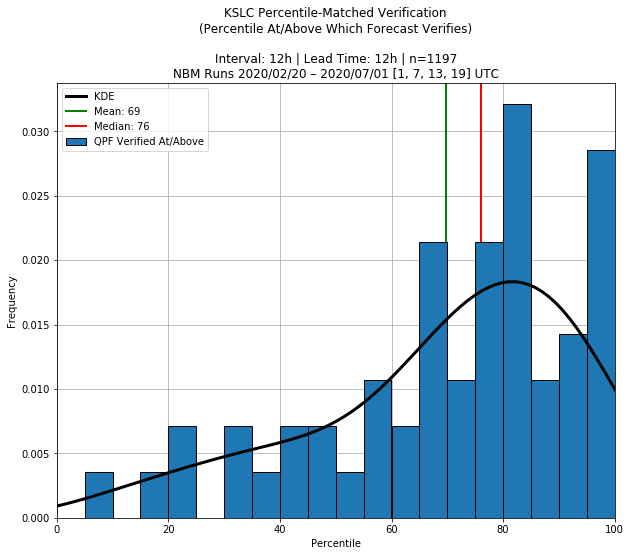

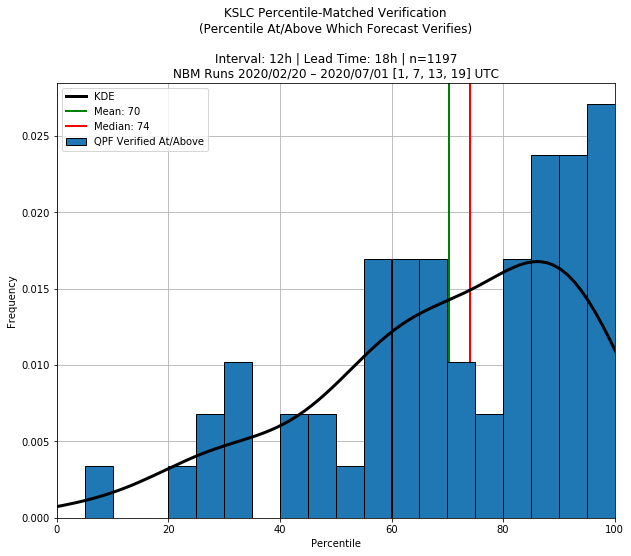

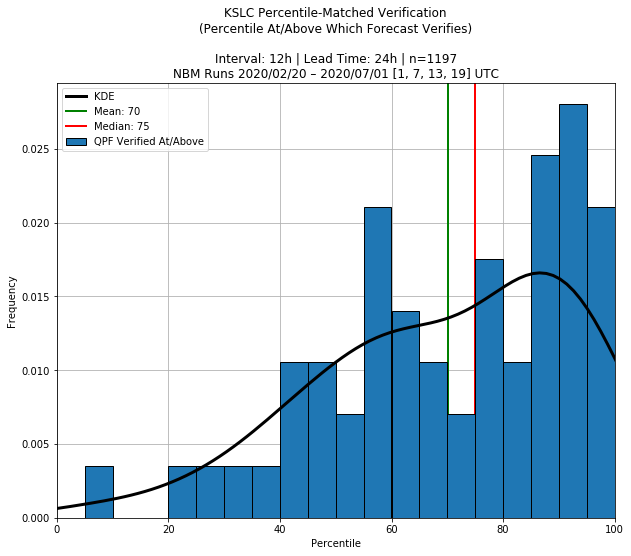

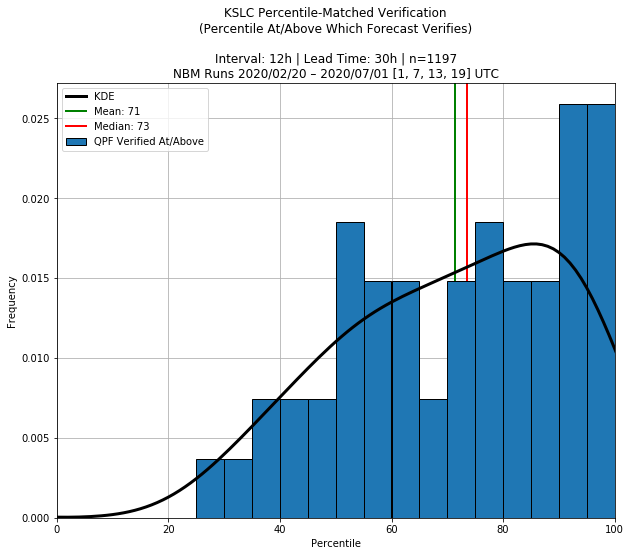

In [133]:
interval = 12

for lead_time in np.arange(interval, 36, 6):
    
    fig, ax = plt.subplots(1, figsize=(10, 8))
    bins = np.arange(0, 101, 5)
    
    verif_perc = nbm_perc[interval][lead_time].merge(obs['%sh_precip_mm'%interval], on='ValidTime')

    vlevel, vamt, vamt_fx = [], [], []
    for i in range(len(verif_perc)):

        vv = verif_perc.iloc[i, -1]
        if vv > 0:

            vp = np.searchsorted(verif_perc.iloc[i, :-1].values, vv, 'right')
            # vp = np.argmin(abs(verif_perc.iloc[i, :-1].values - vv))
            vlevel.append(vp)
            vamt.append(vv)

            # THE VALUE FOR VP DISPLAYED IS THE PERCENTILE ABOVE WHICH THE FORECAST VERIFIED
            # Therefore, a value of 65 means the observed value verified between the 65th and 66th percentile
            # (Switch to vp+2 to get the percentile verified below)
            try:
                vf = verif_perc.iloc[i, :-1][vp]
                # print(vp+1, verif_perc.iloc[i, :-1][vp-1], vv, verif_perc.iloc[i, :-1][vp])

            except:
                vp -= 1
                vf = verif_perc.iloc[i, :-1][vp]
                # print(vp+1, verif_perc.iloc[i, :-1][vp-1], vv, verif_perc.iloc[i, :-1][vp])

            vamt_fx.append(vf)

    vlevel = np.array(vlevel)
    vamt = np.array(vamt)
    vamt_fx = np.array(vamt_fx)

    ax.hist(vlevel, bins=bins, edgecolor='k', color='C0', zorder=10, density=True, label='QPF Verified At/Above')
    sns.kdeplot(vlevel, ax=ax, zorder=10, color='k', linewidth=3, label='KDE')
    
    ax.axvline(np.nanmean(vlevel), label='Mean: %d'%np.nanmean(vlevel), color='g', linewidth=2)
    ax.axvline(np.percentile(vlevel, 50), label='Median: %d'%np.percentile(vlevel, 50), color='r', linewidth=2)

    ax.set_xlim([0, 100])
    ax.set_xlabel('Percentile')
    ax.set_ylabel('Frequency')
    
    ax.set_title(('{} Percentile-Matched Verification\n(Percentile At/Above Which Forecast Verifies)' + 
                  '\n\nInterval: {}h | Lead Time: {}h | n={}\nNBM Runs {} – {} {} UTC').format(
        site, interval, lead_time, len(vlevel_all), date0.strftime('%Y/%m/%d'), date1.strftime('%Y/%m/%d'), init_hours))
    
    ax.grid()
    ax.legend()
    
    plt.show()

24 24


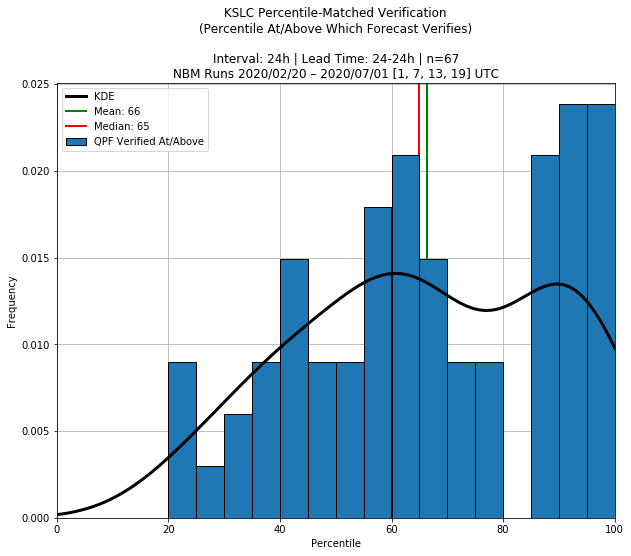

24 48


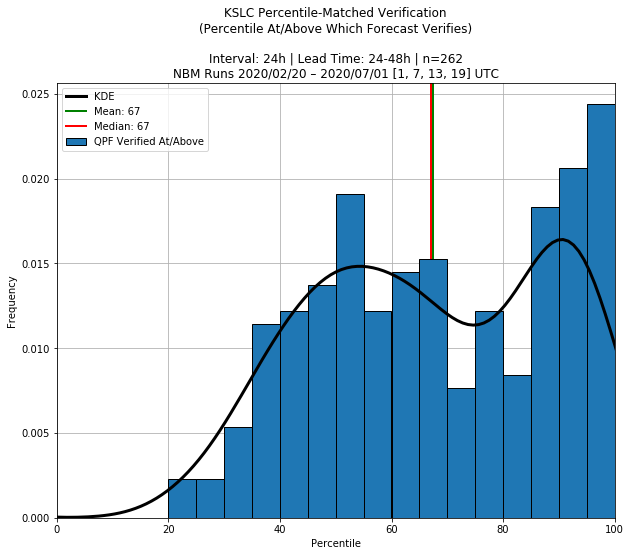

24 72


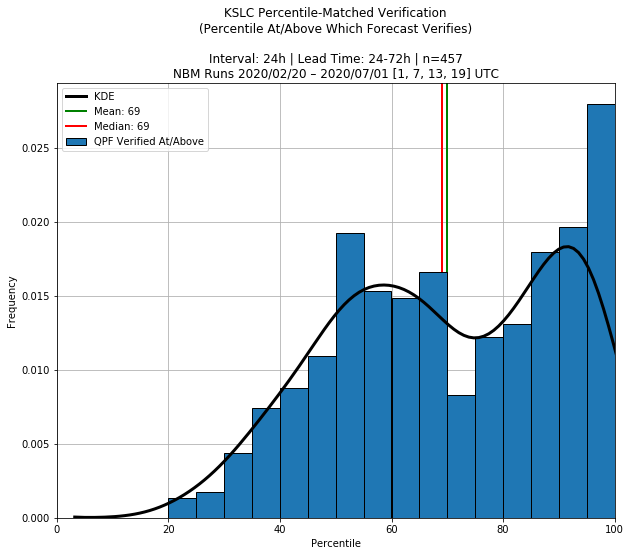

24 120


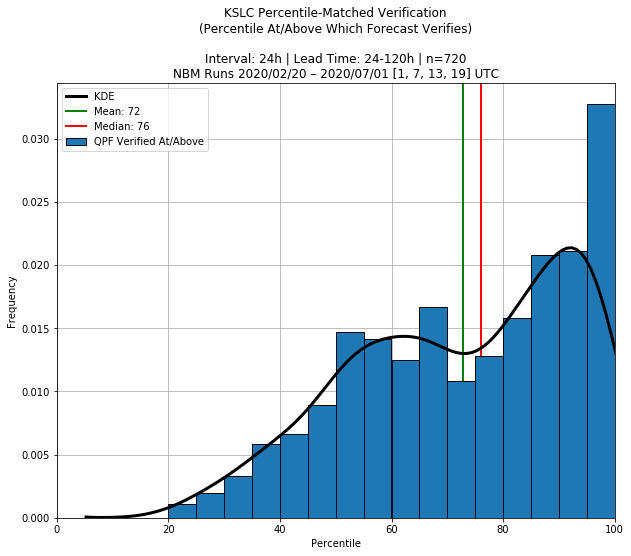

24 240


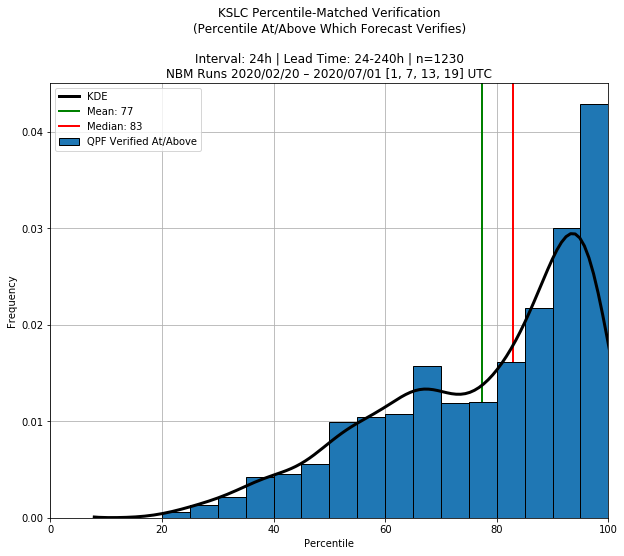

48 48


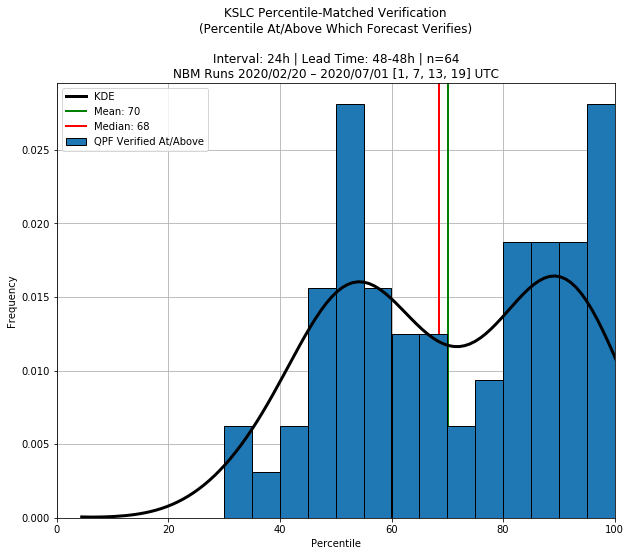

48 72


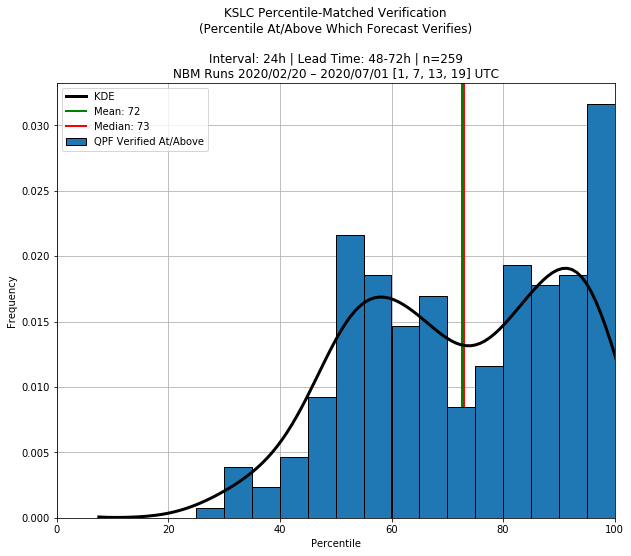

48 120


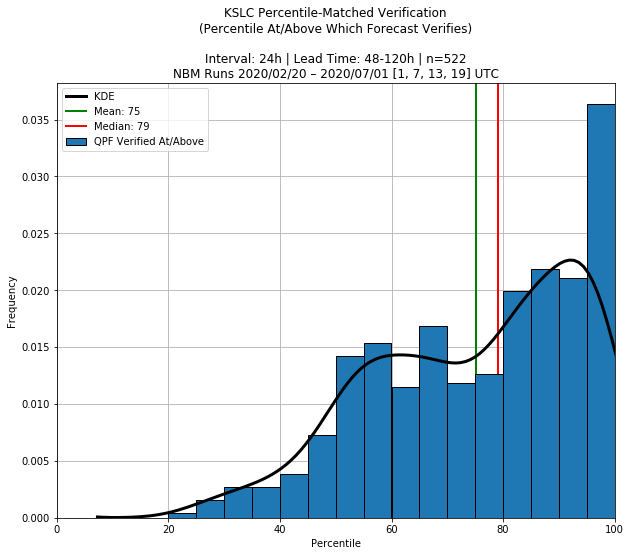

48 240


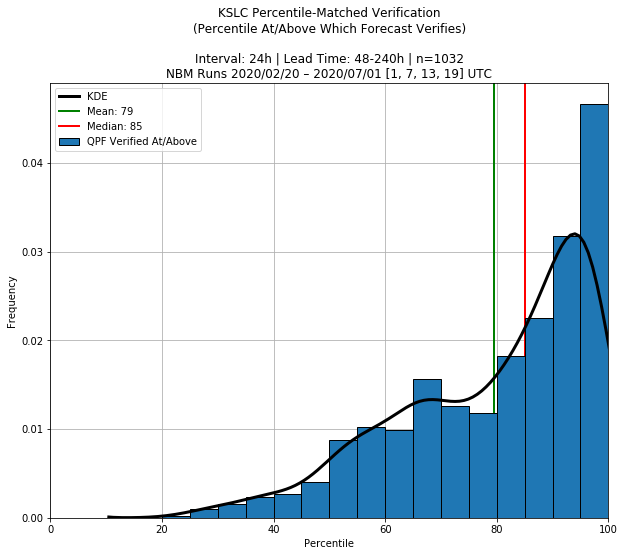

72 72


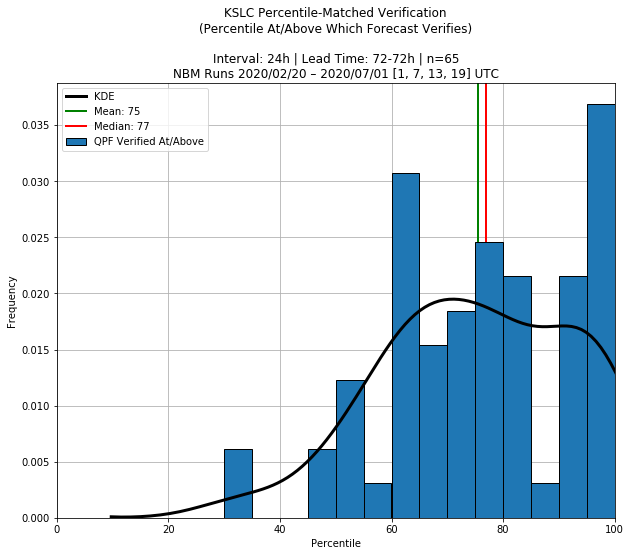

72 120


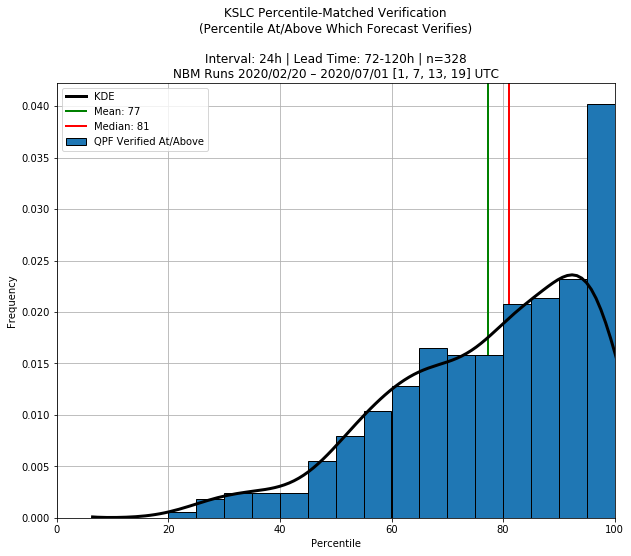

72 240


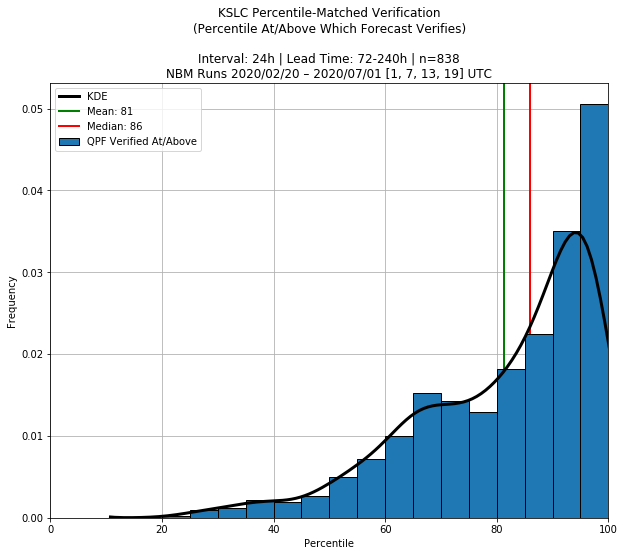

120 120


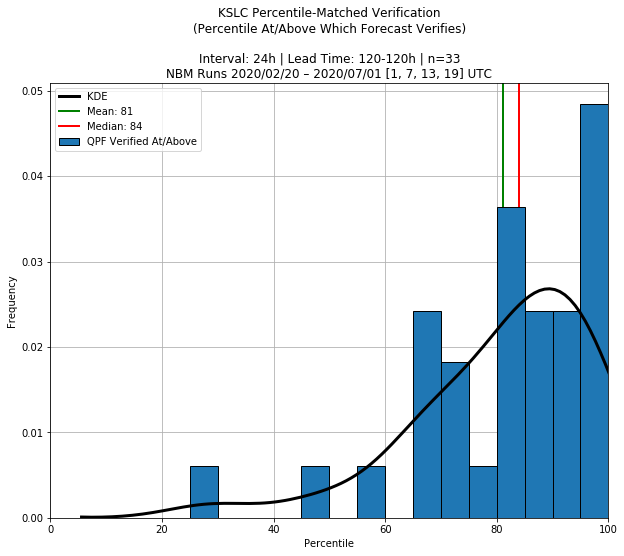

120 240


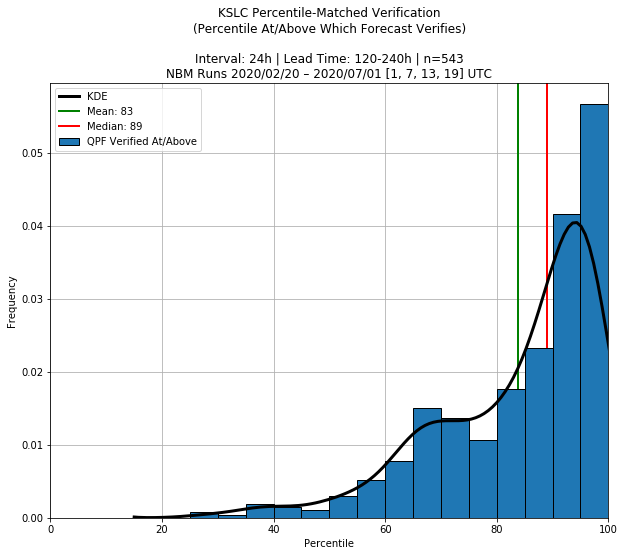

In [152]:
interval = 24

for short_lead in [24, 48, 72, 120]:
    for long_lead in [24, 48, 72, 120, 240]:
        if long_lead >= short_lead:
            
            print(short_lead, long_lead)

            vlevel_all = []
            for lead_time in np.arange(short_lead, long_lead+1, 6):

                verif_perc = nbm_perc[interval][lead_time].merge(obs['%sh_precip_mm'%interval], on='ValidTime')

                vlevel, vamt, vamt_fx = [], [], []
                for i in range(len(verif_perc)):

                    fv = verif_perc.iloc[i, :-1].values
                    vv = verif_perc.iloc[i, -1]

                    if ((vv > .254) & (len(np.where(np.isnan(fv))[0]) == 0)):

                        vp = np.searchsorted(fv, vv, 'right') -1
                        # vp = np.argmin(abs(verif_perc.iloc[i, :-1].values - vv))

                        vlevel.append(vp)
                        vamt.append(vv)

                        # THE VALUE FOR VP DISPLAYED IS THE PERCENTILE ABOVE WHICH THE FORECAST VERIFIED
                        # Therefore, a value of 65 means the observed value verified between the 65th and 66th percentile
                        # (Switch to vp+2 to get the percentile verified below)
                        try:
                            vf = verif_perc.iloc[i, :-1][vp]
                            #if vp >= 90:
                            #    print(vp+1, verif_perc.iloc[i, :-1][vp-1], vv, verif_perc.iloc[i, :-1][-10:].values)

                        except:
                            vp -= 1
                            vf = verif_perc.iloc[i, :-1][vp]
                            #if vp >= 90:
                            #    print(vp+1, verif_perc.iloc[i, :-1][vp-1], vv, verif_perc.iloc[i, :-1][-10:].values)

                        vamt_fx.append(vf)

                #vlevel = np.array(vlevel)
                vamt = np.array(vamt)
                vamt_fx = np.array(vamt_fx)

                vlevel_all.extend(vlevel)

            vlevel_all = np.array(vlevel_all)

            fig, ax = plt.subplots(1, figsize=(10, 8))
            bins = np.arange(0, 101, 5)

            ax.hist(vlevel_all, bins=bins, edgecolor='k', color='C0', zorder=10, density=True, label='QPF Verified At/Above')
            sns.kdeplot(vlevel_all, ax=ax, zorder=10, color='k', linewidth=3, label='KDE')

            ax.axvline(np.nanmean(vlevel_all), label='Mean: %d'%np.nanmean(vlevel_all), color='g', linewidth=2)
            ax.axvline(np.percentile(vlevel_all, 50), label='Median: %d'%np.percentile(vlevel_all, 50), color='r', linewidth=2)

            ax.set_xlim([0, 100])
            ax.set_xlabel('Percentile')
            ax.set_ylabel('Frequency')

            ax.set_title(('{} Percentile-Matched Verification\n(Percentile At/Above Which Forecast Verifies)' + 
                          '\n\nInterval: {}h | Lead Time: {}-{}h | n={}\nNBM Runs {} – {} {} UTC').format(
                site, interval, short_lead, long_lead, len(vlevel_all), date0.strftime('%Y/%m/%d'), date1.strftime('%Y/%m/%d'), init_hours))

            ax.grid()
            ax.legend()

            plt.show()